# Fish in Image Detection

dataset: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots

Author: 'Hal' Sterling Halberstadt
Purpose: 
I want to make an object detection and this seemed like a difficult enough problem with a good enough dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input, Model, callbacks, utils, callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from pathlib import Path
from PIL import Image # for resizing images
from IPython.display import display, HTML
from skimage import io, color

# from scipy.signal import find_peaks, periodogram
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler

display(HTML("<style>.container { width:100% !important; }</style>"))

## Image set resizing
since the images in the dataset are different sizes, I am going to resize all the images beforehand so I don't need to add time resizing images in the generator 

The main thing is not to remove data, so that the text files are still accurate

NOTE: the code used to resize the images is in a markdown cell as for you to be able to replicate even though it will not run if directly pulled as is.

In [13]:
# Locations
data_dir = '../Comp_Vis_Proj/aquarium'

test_path = Path(data_dir+'/test/images').glob("*.jpg")
test_list = list(test_path)
train_path = Path(data_dir+'/train/images').glob("*.jpg")
train_list = list(train_path)
valid_path = Path(data_dir+'/valid/images').glob("*.jpg")
valid_list = list(valid_path)

# image constants
img_size = (1024, 1024, 3)
# img_size = (512, 512, 3)

for current_list in [test_list, train_list, valid_list]:
    for i, ID in enumerate(current_list):
        # get image location
        image_location = str(ID)
        
        with Image.open(image_location) as image: # code adapted from https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
            old_size = image.size  # old_size[0] is in (width, height) format

            ratio = float(img_size[0])/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])

            image = image.resize(new_size, Image.ANTIALIAS)

            new_im = Image.new("RGB", (img_size[0], img_size[0]))
            new_im.paste(image, ((img_size[0]-new_size[0])//2, (img_size[0]-new_size[1])//2))
            
            # new_im.show();
            new_im.save(image_location)

C:\Users\smhal\AppData\Local\Temp\ipykernel_1748\1679348421.py:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(new_size, Image.ANTIALIAS)


### Python code for resizing images:

```
for current_list in [test_list, train_list, valid_list]:
    for i, ID in enumerate(current_list):
        # get image location
        image_location = str(ID)
        
        with Image.open(image_location) as image: # code adapted from https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
            old_size = image.size  # old_size[0] is in (width, height) format

            ratio = float(img_size[0])/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])

            image = image.resize(new_size, Image.ANTIALIAS)

            new_im = Image.new("RGB", (img_size[0], img_size[0]))
            new_im.paste(image, ((img_size[0]-new_size[0])//2, (img_size[0]-new_size[1])//2))
            
            # new_im.show();
            new_im.save(image_location)
```

Now I need to grab the file(s) with the data, I am also then going to make a generator so that I do not need to hold more than a few images in memory at a time.

classes of fish associated with the dataset (pulled from the kaggle page listed above).

In [86]:
fish_classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

### Useful functions

In [87]:
def plot_metric(history, metric='loss'): # credit to Glenn Bruns of CSUMB, this is taken from code provided during his ML course.
    """ Plot training and test values for a metric. """
    plt.figure(figsize=(4,4))
    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

### Generators


In [88]:
class DataGenerator(utils.Sequence): 
    '''
    adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    '''
    def __init__(self, list_IDs_fold, batch_size=10, 
                 dim=img_size, objs=(25, 5), n_channels=3, shuffle=True):
        self.dim = dim
        self.objs = objs
        self.batch_size = batch_size
        self.list_IDs = list_IDs_fold
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs)
        
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, *self.objs))  
                
        
        for i, ID in enumerate(list_IDs_temp):
            # get image location
            image_location = str(ID)
            # print(image_location)
            # shift to fit correct location
            text_location = str(ID).replace("\\images\\", "\\labels\\").replace(".jpg", ".txt")
            
            num_coords = 0
            with open(text_location) as f:
                coord_txt = f.readline().rstrip()
                # print(f"\"{coord_txt}\"")
                if coord_txt == "":
                    y[i] = [-1.0, -1.0, -1.0, -1.0, -1.0]
                else:
                    y[i] = [float(i) for i in coord_txt.split()]
                # num_coords += 1
                
            # X[i] = load_img(image_location).resize((512,512))
            X[i] = load_img(image_location).resize((1024, 1024))
                    
        return X, y

In [89]:
 # Generators
test_generator = DataGenerator(test_list)
train_generator = DataGenerator(train_list)
valid_generator = DataGenerator(valid_list)

In [90]:
K.clear_session()

# Training

In [91]:
inputs = Input((img_size), name="img_input")

x = layers.SeparableConv2D(10, (200,200), activation='relu')(inputs)
x = layers.SeparableConv2D(10, (300,300), activation='relu')(x)
x = layers.SeparableConv2D(10, (200,200), activation='relu')(x)
x = layers.SeparableConv2D(10, (300,300), activation='relu')(x)

x = layers.Dense(10, activation='relu')(x)
x = layers.Reshape((784, 10))(x)
x = layers.SeparableConv1D(10, (300), activation='relu')(x)
x = layers.SeparableConv1D(10, (250), activation='relu')(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(25, activation='relu')(x)
x = layers.Dense(5, activation='relu')(x)

model = Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 825, 825, 10)      120040    
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 526, 526, 10)      900110    
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 327, 327, 10)      400110    
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 28, 28, 10)        900110    
_________________________________________________________________
dense (Dense)                (None, 28, 28, 10)        110       
_________________________________________________________________
reshape (Reshape)            (None, 784, 10)           0     

I want to create a loss function that is able to have the weights of correct fish Identification be able to be weighed differently than 

In [92]:
model.compile(optimizer='RMSprop', loss='mean_squared_error',  metrics=['accuracy'])

history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=10, verbose=1)

Epoch 1/10


KeyboardInterrupt: 

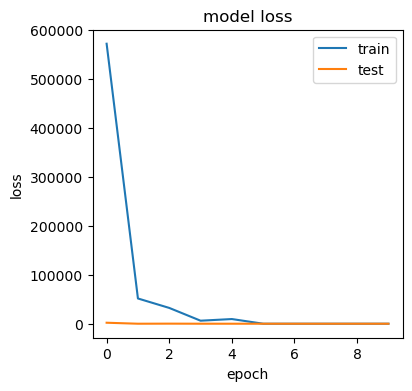

In [ ]:
plot_metric(history)